In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import seaborn as sns

In [4]:
# 1) Load dataset
df = pd.read_csv("../data/bodyfat.csv")  # <-- change to your path
print("Shape:", df.shape)
df.head()

Shape: (252, 15)


,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [5]:
# 2) Detect target column
target = "BodyFat"  # if your dataset uses another name, change here

In [6]:
# 3) Basic summary
print(df.describe())
print(df.isna().sum())

          Density     BodyFat         Age      Weight      Height        Neck  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean     1.055574   19.150794   44.884921  178.924405   70.148810   37.992063   
std      0.019031    8.368740   12.602040   29.389160    3.662856    2.430913   
min      0.995000    0.000000   22.000000  118.500000   29.500000   31.100000   
25%      1.041400   12.475000   35.750000  159.000000   68.250000   36.400000   
50%      1.054900   19.200000   43.000000  176.500000   70.000000   38.000000   
75%      1.070400   25.300000   54.000000  197.000000   72.250000   39.425000   
max      1.108900   47.500000   81.000000  363.150000   77.750000   51.200000   

            Chest     Abdomen         Hip       Thigh        Knee       Ankle  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean   100.824206   92.555952   99.904762   59.405952   38.590476   23.102381   
std      8.430476   10.7830

In [7]:
# 4) Keep numeric features only
df_num = df.select_dtypes(include=[np.number]).copy()

In [8]:
# 5) Separate X and y
X = df_num.drop(columns=[target])
y = df_num[target]

In [9]:
# 6) Impute missing values
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

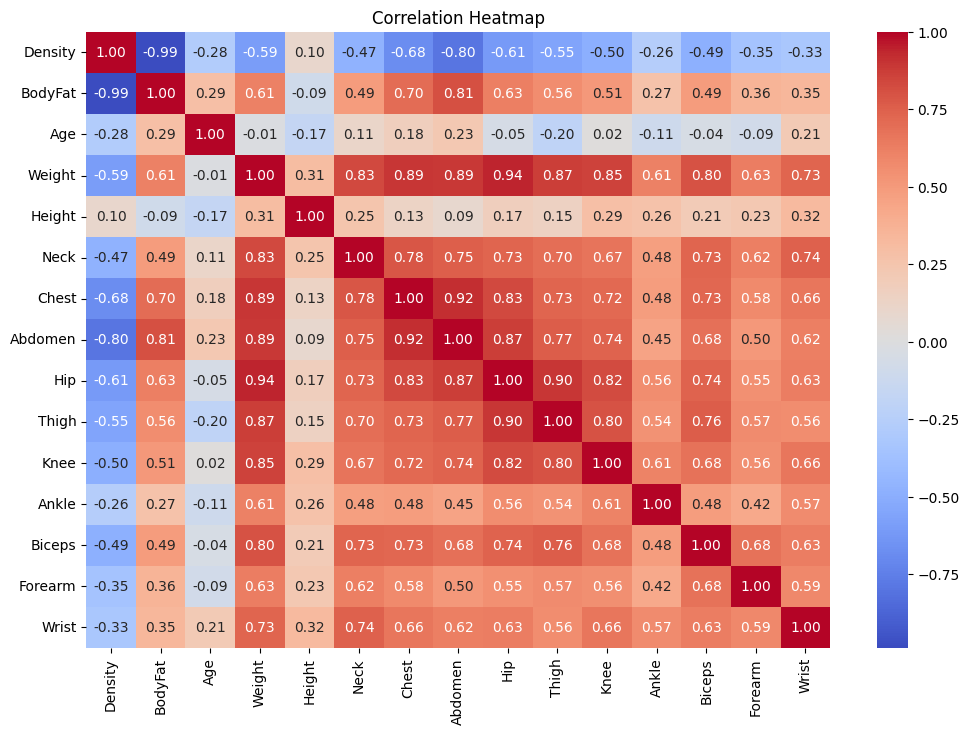

In [14]:
# 7) Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
# 8) VIF (multicollinearity check)
X_vif = sm.add_constant(X_imputed)
vif = pd.DataFrame()
vif["feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

    feature           VIF
0     const  17811.048555
1   Density      3.818257
2       Age      2.274699
3    Weight     34.031683
4    Height      1.677765
5      Neck      4.396475
6     Chest      9.472241
7   Abdomen     18.119895
8       Hip     14.960951
9     Thigh      7.887715
10     Knee      4.612291
11    Ankle      1.920035
12   Biceps      3.651611
13  Forearm      2.236999
14    Wrist      3.521509


### Select Feature

In [16]:
selected_features = [
    'Density', 'Age', 'Height', 'Neck', 'Thigh', 'Knee', 'Ankle',
    'Biceps', 'Forearm', 'Wrist', 'Chest'
]
X_selected = X_imputed[selected_features]

In [17]:
# 9) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [18]:
# 10) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 11) Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [21]:
# 12) Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.474062022138886
MAE: 0.39905265576247373
R²: 0.9951688709147988


### Select Feature with prioritize predictive power

In [36]:
selected_features = ['Abdomen', 'Wrist', 'Forearm', 'Density']
X_selected = X_imputed[selected_features]
X_selected

,Abdomen,Wrist,Forearm,Density
0,85.2,17.1,27.4,1.0708
1,83.0,18.2,28.9,1.0853
2,87.9,16.6,25.2,1.0414
3,86.4,18.2,29.4,1.0751
4,100.0,17.7,27.7,1.0340
...,...,...,...,...
247,83.6,18.5,25.7,1.0736
248,105.0,20.1,28.6,1.0236
249,111.5,18.0,27.2,1.0328
250,101.3,19.8,29.4,1.0399


In [37]:
# 9) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [38]:
# 10) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# 11) Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [40]:
# 12) Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.5429814655370572
MAE: 0.4003310372461653
R²: 0.9936620570869054


### Select Feature with prioritize stable VIF

In [41]:
selected_features = ['Density', 'Wrist', 'Forearm', 'Neck', 'Thigh']
X_selected = X_imputed[selected_features]
X_selected

,Density,Wrist,Forearm,Neck,Thigh
0,1.0708,17.1,27.4,36.2,59.0
1,1.0853,18.2,28.9,38.5,58.7
2,1.0414,16.6,25.2,34.0,59.6
3,1.0751,18.2,29.4,37.4,60.1
4,1.0340,17.7,27.7,34.4,63.2
...,...,...,...,...,...
247,1.0736,18.5,25.7,34.9,49.6
248,1.0236,20.1,28.6,40.9,59.6
249,1.0328,18.0,27.2,38.9,60.3
250,1.0399,19.8,29.4,38.9,56.0


In [42]:
# 9) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [43]:
# 10) Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# 11) Train Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [45]:
# 12) Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.4512873842174813
MAE: 0.3554322217840107
R²: 0.9956219098670327


### New for testing

In [ ]:
feature_sets = {
    "Full Reduced": ['Density', 'Age', 'Height', 'Neck', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'Chest'],
    "Best 5": ['Density', 'Wrist', 'Forearm', 'Neck', 'Thigh'],
    "Density Only": ['Density'],
    "Based on correlation": ['Abdomen', 'Chest', 'Hip', 'Weight', 'Thigh', 'Neck', 'Wrist']
}

In [52]:
results = []

for name, features in feature_sets.items():
    X_sel = X_imputed[features]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.2, random_state=42
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, rmse, mae, r2])

In [57]:
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
print(results_df)

                  Model      RMSE       MAE        R2
0          Full Reduced  0.474062  0.399053  0.995169
1                Best 5  0.451287  0.355432  0.995622
2          Density Only  0.268400  0.239242  0.998451
3  Based on correlation  4.196902  3.285926  0.621352


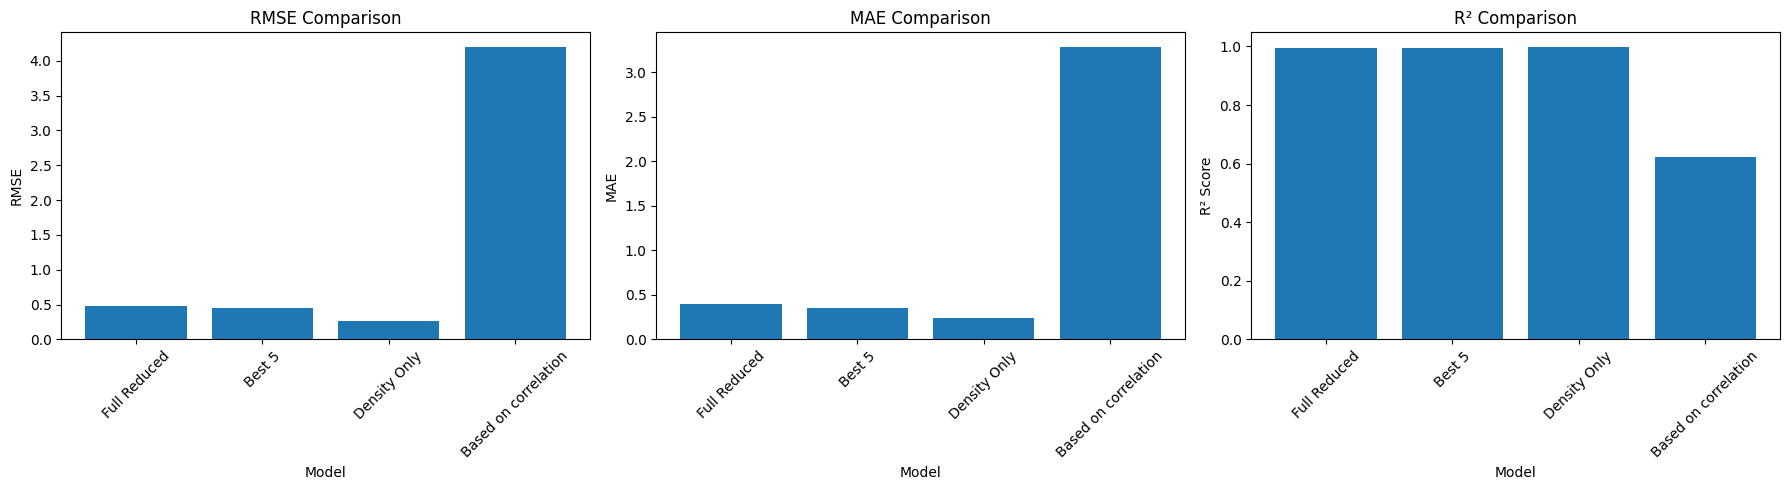

In [54]:
# Plot comparison of RMSE, MAE, and R2 for the three models

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE plot
axes[0].bar(results_df["Model"], results_df["RMSE"])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Model")
axes[0].tick_params(axis='x', rotation=45)

# MAE plot
axes[1].bar(results_df["Model"], results_df["MAE"])
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].set_xlabel("Model")
axes[1].tick_params(axis='x', rotation=45)

# R2 plot
axes[2].bar(results_df["Model"], results_df["R2"])
axes[2].set_title("R² Comparison")
axes[2].set_ylabel("R² Score")
axes[2].set_xlabel("Model")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

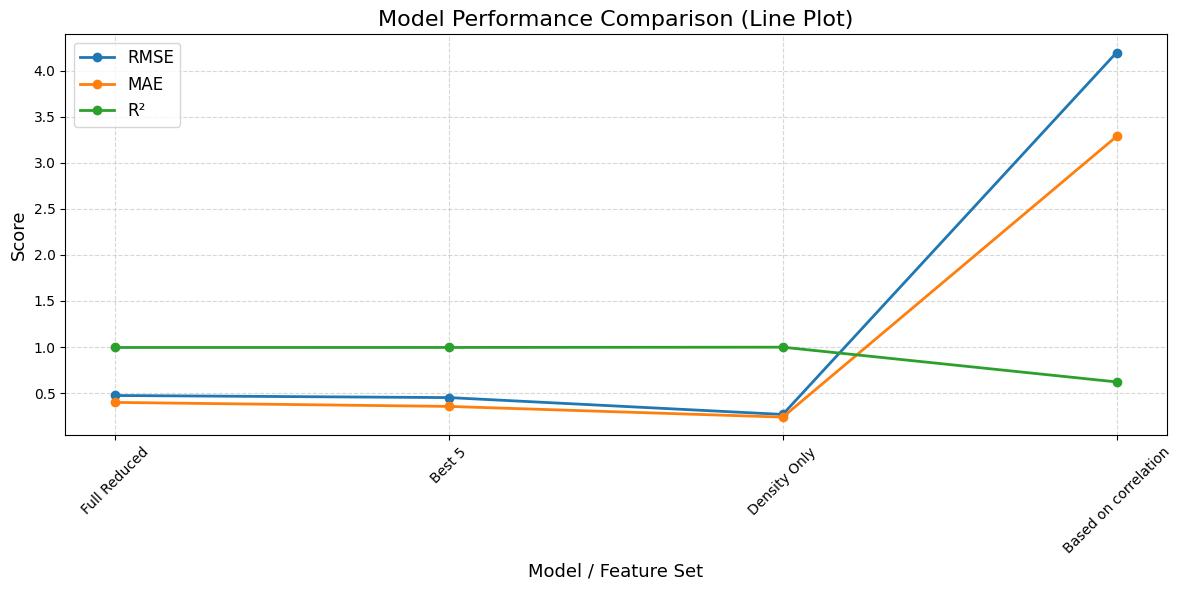

In [56]:
# ---------------------------
# 📌 LINE PLOTS FOR PERFORMANCE
# ---------------------------

plt.figure(figsize=(12, 6))

# RMSE line
plt.plot(results_df["Model"], results_df["RMSE"], marker="o", linewidth=2, label="RMSE")

# MAE line
plt.plot(results_df["Model"], results_df["MAE"], marker="o", linewidth=2, label="MAE")

# R2 line
plt.plot(results_df["Model"], results_df["R2"], marker="o", linewidth=2, label="R²")

plt.title("Model Performance Comparison (Line Plot)", fontsize=16)
plt.xlabel("Model / Feature Set", fontsize=13)
plt.ylabel("Score", fontsize=13)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Since the model comparison table is shown, we see that the model with the density only feature has:
- RSME: 0.268400
- MAE: 0.239242
- R²: 0.998451

it had the lowest RMSE and MAE, and the highest R² among all models tested. This indicates that the model with only the density feature performs the best in predicting body fat percentage compared to other feature sets tested.

In [58]:
# Select Density only
X = df[['Density']]
y = df['BodyFat']

In [59]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [60]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
# Predictions
y_pred = model.predict(X_test)

In [62]:
# Eval metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)

RMSE: 0.2683995571062006
R2 Score: 0.998451390560776


In [63]:
# Save model
joblib.dump(model, "../model/density_model.pkl")
print("Model saved as density_model.pkl")

Model saved as density_model.pkl
